## Imports and Settings

In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')


## Generate synthetic dataset

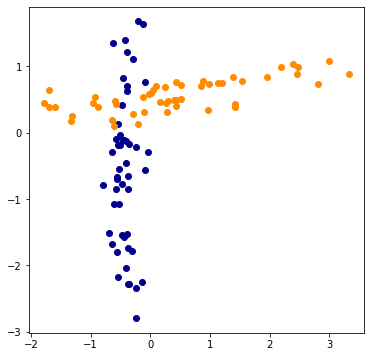

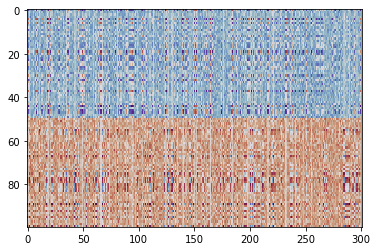

In [2]:
# Synthetic data parameters
num_vars = 300 # number of varibles p
density = 0.5 # redundancy delta
cluster_sizes = [50,50] # cluster sizes N_1 and N_2
cluster_means = [-.25,.25] # cluster mean start values, 'non-overlapping'data
#cluster_means = [-0.05,0.005] # cluster mean start values, 'overlapping' data
sigma=0.075 # noise coefficient

# Generate and plot synthetic two cluster data
X_c, true_clusters = two_cluster_data(m=cluster_sizes, means=cluster_means, n_X=num_vars, sigma=sigma, density=density, 
                                    gen_seeds=False, seeds=range(14,200), plot=False, scale_data=True, intercept=True)

# Change order for running consensus batches
np.random.seed(seed=1234)
idx_perm = np.random.permutation(X_c.shape[0])
X_all = X_c[idx_perm,:]
true_clusters_all = true_clusters[idx_perm]

# Scatter plot of two cluster synthetic data
plt.figure(figsize=(6,6))
plt.scatter(X_all[true_clusters_all==0,0], X_all[true_clusters_all==0,1], c='darkblue')
plt.scatter(X_all[true_clusters_all==1,0], X_all[true_clusters_all==1,1], c='darkorange' )

# Plot data matrix as image
plt.figure()
maxval = np.max(np.abs(X_c))
plt.imshow(X_c,aspect='auto',interpolation='nearest',cmap='twilight_shifted',vmin=-1*maxval, vmax=maxval)  



### Run PCMF ADMM

In [ ]:
# Set decreasing penalty list, "burning in" single cluster solution by starting with \lambda = np.inf
penalty_list = np.concatenate((np.repeat(np.inf,10),np.exp(np.linspace(-10,2.5,150))[::-1]),axis=0)

# Fit PCMF ADMM along penalty list with rho=1.5, 10 admm iterations per PALS iteration, gamma=2.0, and 25 nearest neighbors
A_list_full, U_list_full, s_list_full, Vh_list_full = pcmf_ADMM(X_all, penalty_list, problem_rank=1, rho=1.5, admm_iters = 10, numba=True, gauss_coef=2.0, weights='Gaussian', neighbors=25)

# Plot estimates along path for first three variables
path_plot(np.asarray(A_list_full)[:,:,0:3], penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)

# Plot estimates along path separated by true cluster label for first three variables
path_plot(np.asarray(A_list_full)[:, true_clusters_all==0,0:3], penalty_list, plot_range=[0,-1])
path_plot(np.asarray(A_list_full)[:, true_clusters_all==1,0:3], penalty_list, plot_range=[0,-1])

 

### Cluster along path

In [ ]:
# Estimate clusters along path using spectral clustering on diffenences defined by dual variables (sequential Chi & Lange, 2015)
from pcmf import fit_spectral

ari_list=[]
nmi_list=[]
for p in range(len(penalty_list)):
    labels, ari, nmi, acc = fit_spectral(np.array(A_list_full)[p,:,:], true_clusters_all, len(np.unique(true_clusters_all)))
    ari_list.append(ari)
    nmi_list.append(nmi)

print('Best Penalty IDX:',np.argmax(np.array(ari_list)), 'ARI:',np.max(np.array(ari_list)), 'NMI:',np.max(np.array(nmi_list)))



### Run PCMF PALS

In [ ]:
# Set decreasing penalty list, "burning in" single cluster solution by starting with \lambda = np.inf
penalty_list = np.concatenate((np.repeat(np.inf,10),np.exp(np.linspace(-10,2.5,150))[::-1]),axis=0)

# Fit PCMF PALS along penalty list with rho=1.5, 10 admm iterations per PALS iteration, gamma=2.0, and 25 nearest neighbors
V_list_pals, u_list_pals, s_list_pals = pcmf_PALS(X_all, penalty_list, rho = 1.5, admm_iters=10, gauss_coef=2.0, weights = 'Gaussian', neighbors=25, numba = True)

# Reconstruct estimates along path
A_list_pals = []
for i in range(len(penalty_list)):
    A_list_pals.append(u_list_pals[i] * V_list_pals[i])  

# Plot estimates along path for first three variables
path_plot(np.asarray(A_list_pals)[:,:,0:3], penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)

# Plot estimates along path separated by true cluster label for first three variables
path_plot(np.asarray(A_list_pals)[:, true_clusters_all==0,0:3], penalty_list, plot_range=[0,-1])
path_plot(np.asarray(A_list_pals)[:, true_clusters_all==1,0:3], penalty_list, plot_range=[0,-1])



### Cluster along path

In [ ]:
# Estimate clusters along path using spectral clustering to approximate (sequential Chi & Lange, 2015)
ari_list=[]
nmi_list=[]
for p in range(len(penalty_list)):
    labels, ari, nmi, acc = fit_spectral(np.array(A_list_pals)[p,:,:], true_clusters_all, len(np.unique(true_clusters_all)))
    ari_list.append(ari)
    nmi_list.append(nmi)

['Best Penalty IDX:',np.argmax(np.array(ari_list)), 'ARI:',np.max(np.array(ari_list)), 'NMI:',np.max(np.array(nmi_list))]



### Run PCMF ADMM Consensus

In [ ]:
# Set decreasing penalty list, "burning in" single cluster solution by starting with \lambda = np.inf
penalty_list = np.concatenate((np.repeat(np.inf,10),np.exp(np.linspace(-10,2.5,150))[::-1]),axis=0)

# Fit consensus (distributed) PCMF ADMM along penalty list with split size 50, rho=1.5, 10 admm iterations per PALS iteration, gamma=2.0, and 25 nearest neighbors
A_list_full_C, U_list_full_C, s_list_full_C, Vh_list_full_C = pcmf_ADMM_consensus(X_all, penalty_list, split_size=50, problem_rank=1, rho=1.5, admm_iters = 10, gauss_coef=2.0, weights='Gaussian', neighbors=25)

# Plot estimates along path for first three variables
path_plot(np.asarray(A_list_full_C)[:,:,0:3], penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)

# Plot estimates along path separated by true cluster label for first three variables
path_plot(np.asarray(A_list_full_C)[:, true_clusters_all==0,0:3], penalty_list, plot_range=[0,-1])
path_plot(np.asarray(A_list_full_C)[:, true_clusters_all==1,0:3], penalty_list, plot_range=[0,-1])

 

### Cluster along path

In [ ]:
# Estimate clusters along path using spectral clustering on diffenences defined by dual variables (sequential Chi & Lange, 2015)
ari_list=[]
nmi_list=[]
for p in range(len(penalty_list)):
    labels, ari, nmi, acc = fit_spectral(np.array(A_list_full_C)[p,:,:], true_clusters_all, len(np.unique(true_clusters_all)))
    ari_list.append(ari)
    nmi_list.append(nmi)

['Best Penalty IDX:',np.argmax(np.array(ari_list)), 'ARI:',np.max(np.array(ari_list)), 'NMI:',np.max(np.array(nmi_list))]



## Penguins dataset

Install Palmer Penguins data if not already installed

In [ ]:
import sys
!{sys.executable} -m pip install palmerpenguins

Load and plot Palmer Penguins data

(342, 2) (342, 2)


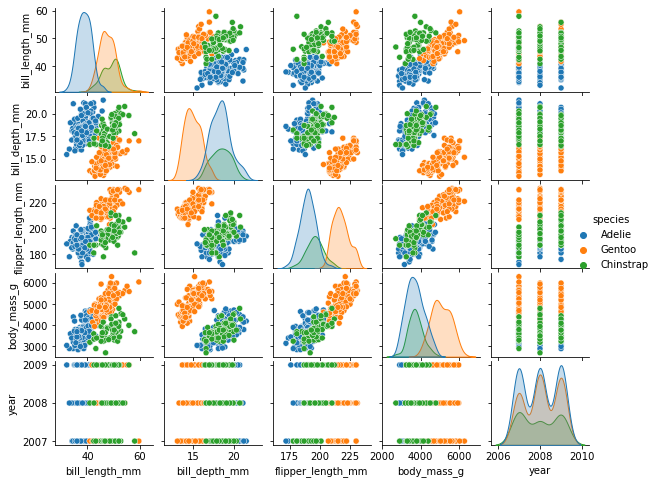

In [11]:
from palmerpenguins import load_penguins
from sklearn.preprocessing import StandardScaler
import seaborn as sns

penguins = load_penguins()

pairplot_figure = sns.pairplot(penguins, hue="species")
pairplot_figure.fig.set_size_inches(9, 6.5)

data,species = load_penguins(return_X_y = True)

data_arr = data.to_numpy() 
data_arr = data_arr[~np.isnan(data).any(axis=1)]
species = species[~np.isnan(data).any(axis=1)]
labels, true_clusters_penguin = np.unique(species, return_inverse=True)

X_penguin = data_arr[:,0:2]
Y_penguin = data_arr[:,2:4]
print(X_penguin.shape, Y_penguin.shape)

scalerX = StandardScaler()
scalerY = StandardScaler()
scalerX.fit(X_penguin)
scalerY.fit(Y_penguin)

X = scalerX.transform(X_penguin)
Y = scalerY.transform(Y_penguin)

X = np.hstack((X,np.ones((X.shape[0],1))))
Y = np.hstack((Y,np.ones((Y.shape[0],1))))

### Run Pathwise Clustered Canonical Correlation Analysis (P3CA) on Palmer Penguins data

In [ ]:
# Set decreasing penalty list
penalty_list = np.exp(np.linspace(-18,4,150))[::-1]

# Fit P3CA along penalty list 
U_list_penguin, V_list_penguin = pcmf_CCA(X, Y, penalty_list, rho=1.5, admm_iters = 3, cca_iters=3, verb=True, weights='Gaussian')

# Plot estimates along path for first three variables for U
path_plot(np.asarray(U_list_penguin)[:,:,0:3], penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)

# Plot estimates along path for first three variables for V
path_plot(np.asarray(V_list_penguin)[:,:,0:3], penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)



### Cluster along path

In [ ]:
# Estimate clusters along path using spectral clustering on diffenences defined by dual variables (sequential Chi & Lange, 2015)
ari_list=[]
nmi_list=[]
for p in range(len(penalty_list)):
    labels, ari, nmi, acc = fit_spectral(np.hstack((np.array(U_list_penguin)[p,:,:],np.array(V_list_penguin)[p,:,:])), true_clusters_penguin, len(np.unique(true_clusters_penguin)))
    ari_list.append(ari)
    nmi_list.append(nmi)

['Best Penalty IDX:',np.argmax(np.array(ari_list)), 'ARI:',np.max(np.array(ari_list)), 'NMI:',np.max(np.array(nmi_list))]
